# NWB conversion tutorial 

This notebook contains a step-by-step tutorial for converting your NeuroPAL structural images and calcium activity time series to the NWB format and uploading to the DANDI archive. One NWB file will contain all of the raw data, processed data, and metadata associated with one trial of an experiment in one worm.

We will show an example of NWB conversion using a dataset collected by Raymond Dunn in the FOCO lab at UCSF. This dataset contains the raw neuroPAL and GCaMP data saved as tif files and neuron segmentation results as well as GCaMP quantification data saved as csv files. This tutorial will also work with data stored in different formats, but you may have to add some additional or different steps to load that data into the proper format for NWB files.

This tutorial should cover most basic applications of optical physiology in *C. elegans*. NWB can also flexibly incorporate many other types of data as well. See https://pynwb.readthedocs.io/en/stable/tutorials/index.html for documentation and tutorials on other types of data as well.

We hope for this process to be a collaborative effort for the worm community. Please feel free to reach out to daniel.sprague@ucsf.edu with any questions or suggestions for changes.

### Data used in this tutorial

This box folder https://ucsf.box.com/s/8kbdfywefcfsn4pfextrzcr25az1vmuj contains a video explaining this tutorial step by step. It also contains a data folder with the example data that is used in this tutorial. Please download the data folder to your local drive to follow along in the tutorial.

### Imports and setup

Below are the necessary imports you need to work with your data and interface with NWB.

You can use the setup.py file found in this repository to automatically add all necessary packages to your environment. Create a fresh Python virtual environment and run "pip install ." in the command line while in the root directory of this Git repository. You will also need to run "ipython kernel install --user --name=*name of your environment*" within your virtual environment to use the environment in Jupyter notebook.

There are a number of python environment management platforms out there. Most people in our lab use anaconda https://docs.conda.io/projects/conda/en/stable/. 

We include the bare minimum packages and imports for the example shown in this tutorial. If you have different file types or want to add additional types of data to your NWB file, you may need additional imports as well.

In [1]:
from collections.abc import Iterable
import os

from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import scipy.io as sio
import skimage.io as skio
from tifffile import TiffFile

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries

In [2]:
#Change to location of NWB_tutorial folder on your local system
datapath = '/Users/danielysprague/foco_lab/data/NWB_tutorial/'

### Setting up the NWB file and adding basic metadata

The NWBFile object is the base object which all other objects will be added to. This object holds 
metadata about the experiment, the specific trial, and the lab.

We show an example with the minimum metadata that should be included in any NWB file. Other optional
metadata fields can be found at https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.NWBFile

In [3]:
nwbfile = NWBFile(
    session_description = 'Add a description for the experiment/session. Can be just long form text',
    #Can use any identity marker that is specific to an individual trial. We use date-time to specify trials
    identifier = '20230322-21-41-10',
    #Specify date and time of trial. Datetime entries are in order Year, Month, Day, Hour, Minute, Second. Not all entries are necessary
    session_start_time = datetime(2023, 3, 22, 21, 41, 10, tzinfo=tz.gettz("US/Pacific")),
    lab = 'FOCO lab',
    institution = 'UCSF',
    related_publications = ''
)

nwbfile #in the latest version of PyNWB, you can output the PyNWB object in Jupyter notebook to easily visualize all of the fields contained within the object

root pynwb.file.NWBFile at 0x6002294032
Fields:
  file_create_date: [datetime.datetime(2023, 9, 20, 12, 12, 52, 807860, tzinfo=tzlocal())]
  identifier: 20230322-21-41-10
  institution: UCSF
  lab: FOCO lab
  related_publications: ['']
  session_description: Add a description for the experiment/session. Can be just long form text
  session_start_time: 2023-03-22 21:41:10-07:00
  timestamps_reference_time: 2023-03-22 21:41:10-07:00

The 'subject' object is added onto the nwbfile object and contains the metadata associated with the subject of the
experiment. This should be specific to the worm that you are using for this trial of the experiment.

Please reach out if there are other metadata fields that you think should be included here.

In [4]:
nwbfile.subject = CElegansSubject(
    #This is the same as the NWBFile identifier for us, but does not have to be. It should just identify the subject for this trial uniquely.
    subject_id = '20230322-21-41-10',
    #Age is optional but should be specified in ISO 8601 duration format similarly to what is shown here for growth_stage_time
    #age = pd.Timedelta(hours=2, minutes=30).isoformat(),
    #Date of birth is a required field but if you do not know or if it's not relevant, you can just use the current date or the date of the experiment
    date_of_birth = datetime(2023, 3, 20, tzinfo=tz.gettz("US/Pacific")), 
    #Specify growth stage of worm - should be one of two-fold, three-fold, L1-L4, YA, OA, dauer, post-dauer L4, post-dauer YA, post-dauer OA
    growth_stage = 'YA',
    #Optional: specify time the worm has spent in current growth stage
    growth_stage_time=pd.Timedelta(hours=2, minutes=30).isoformat(),
    #Specify temperature at which animal was cultivated
    cultivation_temp = 20.,
    description = "free form text description, can include whatever you want here",
    #Currently using the ontobee species link until NWB adds support for C. elegans
    species  =  "http://purl.obolibrary.org/obo/NCBITaxon_6239",
    #Currently just using O for other until support added for other gender specifications
    sex = "O", 
    strain = "FC128"
)

nwbfile.subject

subject abc.CElegansSubject at 0x6008175120
Fields:
  age__reference: birth
  cultivation_temp: 20.0
  date_of_birth: 2023-03-20 00:00:00-07:00
  description: free form text description, can include whatever you want here
  growth_stage: YA
  growth_stage_time: P0DT2H30M0S
  sex: O
  species: http://purl.obolibrary.org/obo/NCBITaxon_6239
  strain: FC128
  subject_id: 20230322-21-41-10

The device object is where you specify the metadata of the type of microscope/data acquisition device
used. If there are multiple devices you are using, you can call nwbfile.create_device multiple times. 
Just make sure to give each device a different name and assign it to a different variable. Here we define 
the microscope used to acquire both our NeuroPAL structural images and our calcium imaging time series data.

This device object will be attached to your data objects to show how they were acquired.

In [5]:
device = nwbfile.create_device(
    name = "Spinning disk confocal",
    description = "Leica DMi8 Inverted Microscope with Yokogawa CSU-W1 SoRA, 40x WI objective 1.1 NA",
    manufacturer = "Leica, Yokagawa"
)

device

Spinning disk confocal pynwb.device.Device at 0x6007973648
Fields:
  description: Leica DMi8 Inverted Microscope with Yokogawa CSU-W1 SoRA, 40x WI objective 1.1 NA
  manufacturer: Leica, Yokagawa

### Adding NeuroPAL images

Here we define the ImagingVolume object. This object contains the metadata associated with the image acquisition including
the device used, the scale of the image in each dimension, and the excitation laser/emission filters/fluorophores used for 
each channel in the image.

You can create multiple ImagingVolume objects for each separate type of imaging data that you acquired. As with devices, just
make sure each ImagingVolume has a unique name and variable.

In [6]:
#Channels is a list of tuples where each tuple contains the fluorophore used, the specific emission filter used, and a short description
#structured as "excitation wavelength - emission filter center point- width of emission filter in nm"
#Make sure this list is in the same order as the channels in your data
channels = [("mTagBFP2", "Chroma ET 460/50", "405-460-50m"), ("CyOFP1", "Chroma ET 605/70","488-605-70m"), ("CyOFP1-high filter", "Chroma ET 700/75","488-700-75m"), ("GFP-GCaMP", "Chroma ET 525/50","488-525-50m"), ("mNeptune 2.5", "Chroma ET 700/75", "561-700-75m"), ("Tag RFP-T", "Chroma ET 605/70", "561-605-70m"), ("mNeptune 2.5-far red", "Chroma ET 700/75", "639-700-75m")]


OptChannels = []
OptChanRefData = []
#The loop below takes the list of channels and converts it into a list of OpticalChannelPlus objects which hold the metadata
#for the optical channels used in the experiment
for fluor, des, wave in channels:
    excite = float(wave.split('-')[0])
    emiss_mid = float(wave.split('-')[1])
    emiss_range = float(wave.split('-')[2][:-1])
    OptChan = OpticalChannelPlus(
        name = fluor,
        description = des,
        excitation_lambda = excite,
        excitation_range = [excite-1.5, excite+1.5],
        emission_range = [emiss_mid-emiss_range/2, emiss_mid+emiss_range/2],
        emission_lambda = emiss_mid
    )

    OptChannels.append(OptChan)
    OptChanRefData.append(wave)


#This object just contains references to the order of channels because OptChannels does not preserve ordering by itself
OpticalChannelRefs = OpticalChannelReferences(
    name = 'OpticalChannelRefs',
    channels = OptChanRefData
)

ImagingVol = ImagingVolume(
    name= 'NeuroPALImVol',
    #Add connections to the OptChannels and OpticalChannelRefs objects
    optical_channel_plus = OptChannels,
    order_optical_channels = OpticalChannelRefs,
    #Free form description of what is being imaged in this volume
    description = 'NeuroPAL image of C. elegans brain',
    #Reference the device created earlier that was used to acquire this data
    device = device,
    #Specifies where in the C. elegans body the image is being taken of
    location = "Head",
    #Specifies the voxel spacing in x, y, z respectively. The values specified should be how many micrometers of physical
    #distance are covered by a single pixel in each dimension
    grid_spacing = [0.3208, 0.3208, 0.75],
    grid_spacing_unit = 'micrometers',
    #Origin coords, origin coords unit, and reference frames are carry over fields from other model organisms where you 
    #are likely only looking at a small portion of the brain. These fields are unfortunately required but feel free to put
    #whatever feels right here
    origin_coords = [0, 0, 0],
    origin_coords_unit = "micrometers",
    reference_frame = "Worm head"
)

nwbfile.add_imaging_plane(ImagingVol) #add this ImagingVol to the nwbfile 

ImagingVol

NeuroPALImVol ndx_multichannel_volume.ndx_multichannel_volume.ImagingVolume at 0x6006583504
Fields:
  conversion: 1.0
  description: NeuroPAL image of C. elegans brain
  device: Spinning disk confocal pynwb.device.Device at 0x6007973648
Fields:
  description: Leica DMi8 Inverted Microscope with Yokogawa CSU-W1 SoRA, 40x WI objective 1.1 NA
  manufacturer: Leica, Yokagawa

  excitation_lambda: 0.0
  grid_spacing: [0.3208 0.3208 0.75  ]
  location: Head
  optical_channel_plus: (
    mTagBFP2 <class 'abc.OpticalChannelPlus'>,
    CyOFP1 <class 'abc.OpticalChannelPlus'>,
    CyOFP1-high filter <class 'abc.OpticalChannelPlus'>,
    GFP-GCaMP <class 'abc.OpticalChannelPlus'>,
    mNeptune 2.5 <class 'abc.OpticalChannelPlus'>,
    Tag RFP-T <class 'abc.OpticalChannelPlus'>,
    mNeptune 2.5-far red <class 'abc.OpticalChannelPlus'>
  )
  order_optical_channels: OpticalChannelRefs abc.OpticalChannelReferences at 0x6008680976
Fields:
  channels: ['405-460-50m' '488-605-70m' '488-700-75m' '488-525-50m' '561-700-75m'
 '561-605-70m' '639-700-75m']

  origin_coords: [0 0 0]
  reference_frame: Worm head
  unit: meters

In [7]:
OpticalChannelRefs

OpticalChannelRefs abc.OpticalChannelReferences at 0x6008680976
Fields:
  channels: ['405-460-50m' '488-605-70m' '488-700-75m' '488-525-50m' '561-700-75m'
 '561-605-70m' '639-700-75m']

The next step is to create the MultiChannelVolume object which is where our volumetric images (e.g. NeuroPAL)
will be stored.

The data that is being stored here will be a 4D array: X, Y, Z, C. Each entry of the array will be the grey count
value for the pixel located at a specific X, Y, Z location in a specific channel.

We use tif files to store this data in our lab so the example here will be shown with tifs, but this can work 
with any file type that can be loaded and converted into a numpy array.

Make sure you know the order of the dimensions of your data when inputting here. The order should be X, Y, Z, C. The channels must be the last dimension, but what
you define as X, Y, Z is somewhat arbitrary. For our imaging conditions, we define Z to be the slices and X, Y to refer to the 
dimensions of each slice. Then X is the longer of those two dimensions. It is up to you how you want to define these dimensions, 
just make sure that the order of the dimensions you choose is consistent with the order of dimensions for the pixel resolution you 
input here and the segmentation masks which we will define later.

Again, you can have any number of these images in one NWBfile, just make sure they are all named uniquely and that you provide
a reference to the correct Imaging Volume object for each image.

In [10]:
raw_file = datapath+ 'NP_im_raw.tif'

#Data is in order C, Z, Y, X when reading in 
data = skio.imread(raw_file)
print(data.shape)
data = np.transpose(data) #Tranpose data to proper order
print(data.shape)

RGBW_channels = [0,1,4,6]

Image = MultiChannelVolume(
    name = 'NeuroPALImageRaw',
    #This is the same OpticalChannelRefs used in the associated Imaging Volume
    order_optical_channels = OpticalChannelRefs,
    description = 'free form description of image',
    #Specifies which channels in the image are associated with the RGBW channels - should be a list of channel indices as shown above
    RGBW_channels = RGBW_channels,
    #This is the raw data numpy array that we loaded above
    data = data,
    #This is a reference to the Imaging Volume object we defined previously
    imaging_volume = ImagingVol
)

Image

(7, 48, 240, 1000)
(7, 48, 240, 1000)


TypeError: MultiChannelVolume.__init__: incorrect type for 'data' (got 'H5DataIO', expected 'ndarray, list, tuple, Dataset, Array, StrDataset, HDMFDataset or AbstractDataChunkIterator')

As an example of adding another image, I will also create an image object and associated image volume
for a version of the data that has undergone some basic pre-processing steps. Note that we create a new
imaging volume because this processed image only has 4 channels associated with the RGBW channels, so we
need a separate imaging volume to describe the order of the channels.

In [ ]:
processed_file = datapath+'NP_im_proc.tif'

proc_data = np.transpose(skio.imread(processed_file),[2,1,0,3])

print(proc_data.shape)

proc_channels = [channels[i] for i in RGBW_channels]

ProcOptChannels = []
ProcOptChanRefData = []
for fluor, des, wave in proc_channels:
    excite = float(wave.split('-')[0])
    emiss_mid = float(wave.split('-')[1])
    emiss_range = float(wave.split('-')[2][:-1])
    OptChan = OpticalChannelPlus(
        name = fluor,
        description = des,
        excitation_lambda = excite,
        excitation_range = [excite-1.5, excite+1.5],
        emission_range = [emiss_mid-emiss_range/2, emiss_mid+emiss_range/2],
        emission_lambda = emiss_mid
    )

    ProcOptChannels.append(OptChan)
    ProcOptChanRefData.append(wave)


ProcOpticalChannelRefs = OpticalChannelReferences(
    name = 'OpticalChannelRefs',
    channels = ProcOptChanRefData
)

ProcImagingVol = ImagingVolume(
    name= 'ProcessedImVol',
    optical_channel_plus = ProcOptChannels,
    order_optical_channels = ProcOpticalChannelRefs,
    description = 'NeuroPAL image of C. elegans brain',
    device = device,
    location = "Head",
    grid_spacing = [0.3208, 0.3208, 0.75],
    grid_spacing_unit = 'micrometers',
    origin_coords = [0, 0, 0],
    origin_coords_unit = "micrometers",
    reference_frame = "Worm head"
)

ProcImage = MultiChannelVolume(
    name = 'ProcessedImage',
    order_optical_channels = ProcOpticalChannelRefs,
    description = 'Can describe the specific pre-processing steps taken here',
    RGBW_channels = [0,1,2,3],
    data = proc_data,
    imaging_volume = ProcImagingVol
)

nwbfile.add_imaging_plane(ProcImagingVol)

ProcImage


### Adding segmentation and ID results

Here we add the results of a neuron segmentation to the NWB file using the volume segmentation object. The process described here can be used to add other types of ROIs
as well. As before, just be sure to properly name and describe each of the segmentations you create.

There are two ways of doing this: using an image mask or a voxel mask. I will provide examples of both approaches here, but for the purposes of neuron segmentation, you 
would most likely be best off using the voxel mask approach. Note that each PlaneSegmentation object should have either an image mask or voxel mask and not both.

With image mask, each ROI will be represented by an array which is the same size as the original image where non-ROI voxels have value 0 and ROI voxels have non-zero value.
You should use image mask for ROIs which cover large portions of the image. For example, this would be useful if you were providing an ROI mask for where the body of the worm
is compared to background.

With voxel mask, each ROI is represented by a list of voxels that belong to that ROI. Each entry in this list should have [x, y, z, weight]. The weight should be a float value
which can have any meaning (i.e. could be the grey count of the voxel or a confidence level for that voxel being a member of that ROI). 


Labels should contain an ordered list of labels for the ROIs you include in this segmentation. Labels are optional but if you do include them make sure the list 'labels' is the same length as the number of ROIs you have, using the empty string '' where there is not an associated label. Here, labels contains the annotated cell IDs for the segmented neurons in our image. Please note in the description of the volume segmentation what the weight and 
labels represent.

In the example files we use here, we are only segmenting for the center of neurons and not regions associated with each neuron. The volume segmentation works the same regardless of if 
you have single points or full masks.

In [ ]:
blob_file =  datapath + 'blobs.csv'
blobs = pd.read_csv(blob_file)

IDs = blobs['ID']
labels = IDs.replace(np.nan,'',regex=True)
labels = list(np.asarray(labels)) 
#Need list of ID labels to add as extra column to PlaneSegmentation

vs = PlaneSegmentation(
    name = 'NeuroPALNeurons',
    description = 'Neuron centers for multichannel volumetric image. Weight set at 1 for all voxels. Labels refers to cell ID of segmented neurons',
    #Reference the same ImagingVolume that your image was taken with
    imaging_plane = ImagingVol,
)

#Uncomment the code below to use image_mask instead of voxel_mask
'''
for i, row in blobs.iterrows():
    #image_mask should have the same size as the x, y, z dimensions of the raw image
    image_mask = np.zeros(data.shape[:-1])
    x = row['X']
    y = row['Y']
    z = row['Z']
    ID = row['ID']

    #we define the ROI here as a 3x3x3 region surrounding the neuron center
    image_mask[x-1:x+1, y-1:y+1, z-1:z+1] = 1

    vs.add_roi(image_mask=image_maskS)

'''

#Uncomment the code below to use voxel_mask instead of image_mask
for i, row in blobs.iterrows():
    voxel_mask = []
    x = row['X']
    y = row['Y']
    z = row['Z']

    voxel_mask.append([np.uint(x),np.uint(y),np.uint(z),1]) #If using a segmentation mask rather than neuron center, voxel_mask should be a list of all voxels associated with the ROI

    vs.add_roi(voxel_mask=voxel_mask)

vs.add_column(
     name = 'ID_labels',
     description = 'ROI ID labels',
     data = labels,
     index=True, 
)

NeuroPALImSeg = ImageSegmentation(
    name = 'NeuroPALSegmentation',
)

NeuroPALImSeg.add_plane_segmentation(vs)

NeuroPALImSeg

### Adding calcium imaging data

Here we use the tifffile package to read in our calcium imaging tif files and examine the metadata contained in the file.
We see that there are 18000 pages, each with shape (240, 1000) which are associated with the YX dimensions. For our data,
each page represents a Z slice at a specific point in time. There are 12 Z slices per volume and 1500 time points
(1500*12=18000). 

In [ ]:
from tifffile import TiffFile

tif = TiffFile(datapath+'Calc_series_raw.tiff')

print(len(tif.pages))

page = tif.pages[0]

print(page.shape)
print(page.dtype)
print(page.axes)

series = tif.series[0]
print(series.shape)
print(series.axes)

print(len(tif.pages))

tif.close()


If your calcium imaging data is relatively small (less than a few gigabytes) you may be able to just open your raw files and add the corresponding
data array to an NWB object in just the same way that we did for the NeuroPAL structural images. In practice, most calcium imaging data will be 
much larger than that and likely cannot be loaded all at once into memory. To solve this, we will have to do what's called an iterative data write.

In an iterative data write, we define a method to iteratively load portions of the larger data array and stitch them together in the NWB file. Once
we define the method for generating the data, NWB will handle the rest. See https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/plot_iterative_write.html#sphx-glr-tutorials-advanced-io-plot-iterative-write-py for other examples and information of iterative data writes.

We will use the MultiChannelVolumeSeries object to store our raw calcium images. This object takes in objects of dimensions (T, X, Y, Z, C), representing time points (frames), XYZ image lengths, and number of channels. 

Some recent datasets, especially in freely moving worms, use an additional red reference channel to account for motion artifacts that may be impact the GCaMP signal. Our datasets do not use this reference channel so we have just one channel in our MultiChannelVolumeSeries. Adding additional channels should be easy and can be done in the same way that we do above for our MultiChannelVolumes. Simply add the extra channels to the CalcChannels list, and in your DataChunkIterator function make sure to yield all channels you want included in the image. Make sure to add a comment to the MultiChannelVolume object stsating what information each channel holds. Ex. 'GFP channel contains GCaMP calcium signal, mNeptune contains reference'.


In [ ]:
#define a data generator function that will yield a single data entry, in our case we are iterating over time points and creating a Z stack of images for each time point
def iter_calc_tiff(filename, numZ):

    #TiffFile object allows you to access metadata for the tif file and selectively load individual pages/series
    tif = TiffFile(filename)

    #In this dataset, one page is one XY plane and every 12 pages comprises one Z stack for an individual time point
    pages = len(tif.pages)
    timepoints = int(pages/numZ)

    pageshape = tif.pages[0].shape

    #We iterate through all of the timepoints and yield each timepoint back to the DataChunkIterator
    for i in range(timepoints):
        tpoint = np.zeros((pageshape[1],pageshape[0], numZ))
        for j in range(numZ):
            image = np.transpose(tif.pages[i*numZ+j].asarray())
            tpoint[:,:,j] = image

        #Make sure array ends up as the correct dtype coming out of this function (the dtype that your data was collected as)
        yield tpoint.astype('uint16')

    tif.close()

    return

#The DataChunkIterator wraps the data generator function and will stitch together the chunks as it iteratively reads over the full file
data = DataChunkIterator(
    data= iter_calc_tiff(datapath+'Calc_series_raw.tiff', 12),
    #this will be the max shape of the final image. Can leave blank or set as the size of your full data if you know that ahead of time
    maxshape = None,
    buffer_size = 10,
)

CalcChannels = [("GFP-GCaMP", "Chroma ET 525/50","488-525-50m")]

CalcOptChannels = []
CalcOptChanRefData = []
#The loop below takes the list of channels and converts it into a list of OpticalChannelPlus objects which hold the metadata
#for the optical channels used in the experiment
for fluor, des, wave in CalcChannels:
    excite = float(wave.split('-')[0])
    emiss_mid = float(wave.split('-')[1])
    emiss_range = float(wave.split('-')[2][:-1])
    OptChan = OpticalChannelPlus(
        name = fluor,
        description = des,
        excitation_lambda = excite,
        excitation_range = [excite-1.5, excite+1.5],
        emission_range = [emiss_mid-emiss_range/2, emiss_mid+emiss_range/2],
        emission_lambda = emiss_mid
    )

    CalcOptChannels.append(OptChan)
    CalcOptChanRefData.append(wave)


#This object just contains references to the order of channels because OptChannels does not preserve ordering
CalcOptChanRefs = OpticalChannelReferences(
    name = 'OpticalChannelRefs',
    channels = CalcOptChanRefData
)

CalcImagingVolume = ImagingVolume(
    name = 'CalciumImVol',
    description = 'Imaging volume used to acquire calcium imaging data',
    optical_channel_plus = CalcOptChannels,
    order_optical_channels = CalcOptChanRefs,
    device = device,
    location = 'Worm head',
    grid_spacing = [0.3208, 0.3208, 2.5],
    grid_spacing_unit = 'um',
    reference_frame = 'Worm head'
)

wrapped_data = H5DataIO(data=data, compression="gzip", compression_opts=4)

calcium_image_series = MultiChannelVolumeSeries(
    name="CalciumImageSeries",
    description = "Raw GCaMP series images",
    comments = "Include information about what each channel represents here: e.g. GFP-GCaMP channel represents GCaMP signal, mNeptune represents reference signal",
    data=wrapped_data,
    device = device,
    unit="Voxel gray counts", 
    scan_line_rate = 2995.,
    dimension = [1000,240,12],
    resolution = 1., #smallest meaningful difference (in specified unit) between values in data: i.e. level of precision
    rate = 1.04, #sampling rate in hz
    imaging_volume = CalcImagingVolume,
)


nwbfile.add_imaging_plane(CalcImagingVolume)

calcium_image_series

Now that we have added our calcium imaging raw data to the NWB file, we can add our processed calcium imaging data which consists
of ROI locations and fluorescence for each time point. 

To do this, we will be using the ImageSegmentation, PlaneSegmentation, Fluorescence, and ROIResponseSeries objects native to the Pynwb
OptoPhysiology spec.

Our calcium quantification data is stored in a CSV 'gce_quant.csv' file with columns [Z, Y, X, T, blob_ix, ID, gce_quant]. This is a long dataframe where each row in this CSV file contains the position, cell ID (currently blank in this dataset), and quantification information for each blob at each time point. Every blob_ix should exist at every time point. If a blob is missing from a time point, please add an empty row with just blob_ix filled in. We will add those NaN rows to the volume segmentation and set the weight to 0 to signify missing data.

We initially will convert that CSV file into a 3D numpy array with blob_ix on one dimension, time on another dimension, and X, Y, Z, ID, gce_quant on the final dimension.

We will then create plane segmentations for each time point that contain the locations for each neuron at that time point and load them into
the same ImageSegmentation object. 

We then create an roi_table_region to add the fluorescence data to which indicates which ROIs the fluorescence data applies to (in this case all
of them). The RoiResponseSeries is then wrapped by the DfoF object to indicate that the RoiResponseSeries refers to DfoF data.
There is also a fluorescence object native to PyNWB which does the same thing for raw fluorescence data (i.e. voxel gray counts).

Here I will define three fluorescence objects. One for the green signal channel, one for the red reference channel, and one for the processed data created by correcting the signal channel via the reference channel. Again, we only have the green signal channel in our own data so we will only include that fluorescence signal here, but I am leaving space for the other fluorescence objects commented out here.

In [ ]:
gce_quant = pd.read_csv(datapath+'gce_quant.csv')

print(len(gce_quant['blob_ix'].unique())) #Count the number of unique blobs in this file
print(len(gce_quant['T'].unique())) #Count the number of unique time points in this file

quant = gce_quant[['X', 'Y', 'Z', 'gce_quant', 'ID', 'T', 'blob_ix']] #Reorder columns to order we want

blobquant = None
for idx in gce_quant['blob_ix'].unique():
    blob = quant[quant['blob_ix']==idx]
    blobarr = np.asarray(blob[['X','Y','Z','gce_quant','ID']]) 
    blobarr = blobarr[np.newaxis, :, :]
    if blobquant is None:
        blobquant=blobarr

    else:
        blobquant = np.vstack((blobquant, blobarr))

print(blobquant.shape) #Now dimensions are blob_ix, time, and data columns (X, Y, Z, gce_quant, ID). We are now ready to add this data to NWB objects.

volsegs = []

for t in range(blobquant.shape[1]):
    volseg = PlaneSegmentation(
        name = 'Seg_tpoint_'+str(t),
        description = 'Neuron segmentation for time point ' +str(t) + ' in calcium image series',
        imaging_plane = CalcImagingVolume,
        reference_images = calcium_image_series,
    )

    for i in range(blobquant.shape[0]):
        voxel_mask = blobquant[i,t,0:3] #X, Y, Z columns
        if np.any(np.isnan(voxel_mask)):
            voxel_mask = np.asarray([0,0,0,0]) #if blob does not exist at time point (nan values in row) we replace values with 0 and set weight to 0
        else:
            voxel_mask = np.hstack((voxel_mask, 1)) #add weight of one to each blob
        voxel_mask = voxel_mask[np.newaxis,:] #add empty new axis to make shape compatible

        volseg.add_roi(voxel_mask=voxel_mask)

    volsegs.append(volseg)

ImSeg = ImageSegmentation(
    name = 'CalciumSeriesSegmentation', #use if tracking neurons across frames (correspondence between segmentations)
    #name = 'CalciumSeriesSegmentationUntracked' #use if not trakcing across frames (ie raw segmentation in each frame)
    plane_segmentations = volsegs
)

gce_data = np.transpose(blobquant[:,:,3]) #Take only gce quantification column and transpose so time is in the first dimension

rt_region = volsegs[0].create_roi_table_region(
    description = 'All segmented neurons associated with calcium image series',
    region = list(np.arange(blobquant.shape[0]))
)

#If you have raw fluorescence values rather than DFoF use the Fluorescence object instead of the DfOverF object to save your RoiResponseSeries
SignalRoiResponse = RoiResponseSeries(
    #See https://pynwb.readthedocs.io/en/stable/pynwb.ophys.html#pynwb.ophys.RoiResponseSeries for additional key word argument options
    name = 'SignalCalciumImResponseSeries',
    description = 'DF/F activity for calcium imaging data',
    data = gce_data, #first dimension should represent time and second dimension should represent ROIs
    rois = rt_region,
    unit = 'Percentage', #the unit of measurement for the data input here
    resolution = 0.01,
    rate = 1.04
)

SignalFluor = DfOverF( #Change to Fluorescence if using raw fluorescence
    name = 'SignalDFoF', #Change name to SignalRawFluor if using raw fluorescence, rename reference and processed object accordingly
    roi_response_series = SignalRoiResponse
)

'''

RefRoiResponse = RefRoiResponseSeries(
    #See https://pynwb.readthedocs.io/en/stable/pynwb.ophys.html#pynwb.ophys.RoiResponseSeries for additional key word argument options
    name = 'ReferenceCalciumImResponseSeries',
    description = 'Fluorescence for reference channel in calcium imaging',
    data = ref_data, #first dimension should represent time and second dimension should represent ROIs
    rois = rt_region, 
    unit = '', #the unit of measurement for the data input here
    rate = 4.0
)

RefFluor = DfOverF(
    name = 'ReferenceDFoF',
    roi_response_series = RefRoiResponse
)

ProcRoiResponse = RoiResponseSeries(
    #See https://pynwb.readthedocs.io/en/stable/pynwb.ophys.html#pynwb.ophys.RoiResponseSeries for additional key word argument options
    name = 'ProcessedCalciumImResponseSeries',
    description = 'processed calcium fluorescence activity - describe processing steps taken to obtain',
    data = proc_gce_data, #first dimension should represent time and second dimension should represent ROIs
    rois = rt_region,
    unit = '', #the unit of measurement for the data input here
    rate = 4.0
)

ProcFluor = DfoF(
    name = 'ProcessedDFoF',
    roi_response_series = RoiResponse
)

'''

ImSeg

### Writing the NWB file

Once we have created all the objects that we need to add to the NWB file, the next step is to actually add them to the file and then write the file to a specific location.

Objects are either put in the base acquisition module or in processing modules that users define. Only raw, acquired data should be put into the acquisition module, everything 
else should be put in processing modules. You can define any number of processing modules and add them to the base NWB file, but generally speaking each type of data that you
are adding to the file should have its own processing module. 

In [ ]:
#we add our raw NeuroPAL image to the acquisition module of the base NWB file
nwbfile.add_acquisition(Image)
nwbfile.add_acquisition(calcium_image_series)

#we create a processing module for our neuroPAL data 
neuroPAL_module = nwbfile.create_processing_module(
    name = 'NeuroPAL',
    description = 'NeuroPAL image metadata and segmentation'
)

neuroPAL_module.add(NeuroPALImSeg)
neuroPAL_module.add(OpticalChannelRefs)

#we create a processing module for the pre-processed neuroPAL image
processed_im_module = nwbfile.create_processing_module(
    name = 'ProcessedImage',
    description = 'Data and metadata associated with the processed neuroPAL image'
)

processed_im_module.add(ProcImage)
processed_im_module.add(ProcOpticalChannelRefs)

ophys = nwbfile.create_processing_module(
    name = 'CalciumActivity',
    description = 'Calcium time series metadata, segmentation, and fluorescence data'
)

ophys.add(ImSeg)
ophys.add(SignalFluor)
ophys.add(CalcOptChanRefs)
#ophys.add(RefFluor)
#ophys.add(ProcFluor)


#each NWB file should be named with a unique identifier 
identifier = '20230322-21-41-10'

#specify the file path you want to save this NWB file to 
io = NWBHDF5IO(datapath+'identifier.nwb', mode='w')
io.write(nwbfile)
io.close()


### Reading from existing NWB files

You read NWB files using the same NWBHDF5IO package that was used to write files. 

You can print the entire nwb file to see the contents of the file, including all modules and 
objects present. Each object will be shown in the field as the 'name' field that you assigned 
to that object when creating it. 

NWBHDF5IO does what is called a lazy read. This means when you load the object, it does not 
actually load the whole object into memory. You have to specify specific slices of the data to load.

In the example below we add [:] at the end of the variable declaration to indicate that we want to load
the entirety of that object into the variable. We could also select specific slices of that data.
For example, if we wanted to only load the first 4 channels of one Z slice of the raw neuroPAL data we
could do this by calling read_nwbfile.acquisition['NeuroPALImageRaw].data[:,:,7,0:4]. This indexing 
means we take all of the first two dimensions, the 7th slice of the third dimension (python indexing starts from 0),
and the first 4 slices of the last dimension (the channels). 

This lazy read is especially helpful when working with very large data, like calcium imaging data, because
it allows us to iteratively read in segments of that large data instead of having to load it into memory
all at once. 

In [5]:
with NWBHDF5IO(datapath+'example.nwb', mode='r', load_namespaces=True) as io:
    read_nwbfile = io.read()
    print(read_nwbfile) # you can print the nwbfile after reading to see the contents of the file
    print(read_nwbfile.processing['CalciumActivity'])
    print(read_nwbfile.processing['NeuroPAL'])
    print(read_nwbfile.processing['ProcessedImage'])
    subject = read_nwbfile.subject #get the metadata about the experiment subject
    growth_stage = subject.growth_stage
    image = read_nwbfile.acquisition['NeuroPALImageRaw'].data[:] #get the neuroPAL image as a np array
    channels = read_nwbfile.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
    im_vol = read_nwbfile.acquisition['NeuroPALImageRaw'].imaging_volume #get the metadata associated with the imaging acquisition
    seg = read_nwbfile.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons'].voxel_mask[:] #get the locations of neuron centers
    labels = read_nwbfile.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons']['ID_labels'][:]
    optchans = im_vol.optical_channel_plus[:] #get information about all of the optical channels used in acquisition
    chan_refs = read_nwbfile.processing['NeuroPAL']['OpticalChannelRefs'].channels[:] #get the order of the optical channels in the image
    proc_image = read_nwbfile.processing['ProcessedImage']['ProcessedImage'].data[:] #get the pre-processed image
    calcium_frames = read_nwbfile.acquisition['CalciumImageSeries'].data[0:15, :,:,:] #load the first 15 frames of the calcium images
    fluor = read_nwbfile.processing['CalciumActivity']['SignalDFoF']['SignalCalciumImResponseSeries'].data[:]
    #calc_seg = read_nwbfile.processing['CalciumActivity']['CalciumSeriesSegmentation']['Seg_tpoint_0'].voxel_mask[:]


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.5 because version 0.1.7 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


root pynwb.file.NWBFile at 0x11355340624
Fields:
  acquisition: {
    CalciumImageSeries <class 'ndx_multichannel_volume.ndx_multichannel_volume.MultiChannelVolumeSeries'>,
    NeuroPALImageRaw <class 'ndx_multichannel_volume.ndx_multichannel_volume.MultiChannelVolume'>
  }
  devices: {
    Spinning disk confocal <class 'pynwb.device.Device'>
  }
  file_create_date: [datetime.datetime(2023, 8, 18, 13, 3, 32, 838112, tzinfo=tzoffset(None, -25200))]
  identifier: 20230322-21-41-10
  imaging_planes: {
    CalciumImVol <class 'ndx_multichannel_volume.ndx_multichannel_volume.ImagingVolume'>,
    NeuroPALImVol <class 'ndx_multichannel_volume.ndx_multichannel_volume.ImagingVolume'>,
    ProcessedImagingVolume <class 'ndx_multichannel_volume.ndx_multichannel_volume.ImagingVolume'>
  }
  institution: UCSF
  lab: FOCO lab
  processing: {
    CalciumActivity <class 'pynwb.base.ProcessingModule'>,
    NeuroPAL <class 'pynwb.base.ProcessingModule'>,
    ProcessedImage <class 'pynwb.base.ProcessingM

Now that we've read in our objects from our NWB file, we can run analyses and create visualizations with
the data we have. Here I will show an example of displaying XZ and XY projections of the processed neuroPAL 
image and overlaying the segmented neuron centers on top.

Ideally, you could embed NWB into your full data processing pipeline, saving all of your raw and intermediary
data to the NWB file and reading objects directly from it as well. This eliminates the need to interface with 
almost any additional file types in your pipeline.

In [12]:
labels = ["".join(label) for label in labels]
print(labels)

['', 'I2R', 'I2L', 'MCL', 'MCR', 'MI', 'IL2DL', 'NSML', 'NSMR', 'I3', 'M4', 'IL2L', 'M3L', 'M3R', 'OLQVL', 'IL2VR', 'IL2DR', 'IL2R', 'URADL', 'URBL', 'IL1R', 'IL2VL', 'IL1DL', 'OLLL', 'IL1L', 'IL1DR', 'URADR', 'URYDL', 'URYVL', 'IL1VL', 'IL1VR', 'OLLR', 'URYVR', 'URYDR', 'URBR', 'OLQDL', 'OLQDR', 'RIPL', 'BAGL', 'BAGR', '', 'RMEL', 'URAVL', 'URAVR', 'RMER', 'RMED', 'OLQVR', 'SIADL', 'RMDVR', 'SMDDR', 'CEPVL', 'RID', 'RMDVL', 'CEPVR', 'AVAL', 'SAAVR', 'SAAVL', 'ALA', 'SMDVR', 'AVAR', 'URXR', 'URXL', 'CEPDR', 'RIAR', 'RMDL', 'RMEV', 'RIAL', 'RMDR', 'CEPDL', 'AFDR', 'ASGR', 'SAADL', 'HMC', 'ADFR', 'AWBR', 'AWBL', 'AFDL', 'SMDVL', 'RIVL', 'ASKR', 'ADFL', 'AVHL', 'RIBL', 'AWCR', 'SIBDL', 'SIBVL', 'AVER', 'ASKL', 'AWAR', 'ADLR', 'AVHR', 'AVEL', 'SIBDR', 'SIBVR', 'ASHR', 'ASEL', 'ASHL', 'RMDDR', 'AWCL', 'AWAL', 'AIBR', 'ADLL', 'AVDL', 'ASER', 'ASIR', 'RIBR', 'SAADR', 'RIR', 'ASIL', 'AIBL', 'RMHL', 'SIADR', 'ASGL', 'AVJR', 'RIH', 'RIVR', 'AVDR', 'AVBR', 'AUAR', 'AVBL', 'AVJL', 'AUAL', 'SMBDR',

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 256, 21, 5)
(512, 256, 21, 4)


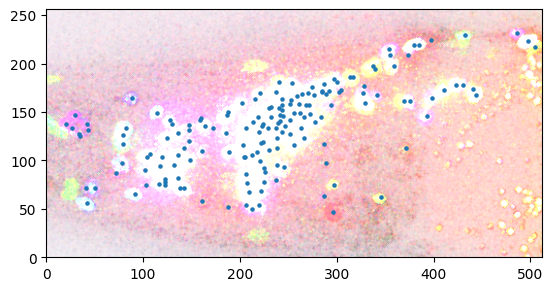

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


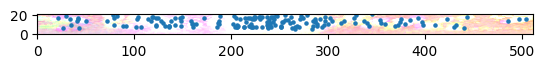

In [17]:
blobs = pd.DataFrame.from_records(seg, columns = ['X', 'Y', 'Z', 'weight', 'ID'])
blobs = blobs.drop(['weight'], axis=1)
blobs = blobs.replace('nan', np.nan, regex=True) 

print(proc_image.shape)

RGB = proc_image[:,:,:,:-1]

print(RGB.shape)

Zmax = np.max(RGB, axis=2)
Ymax = np.max(RGB, axis=1)

plt.figure()

plt.imshow(np.transpose(Zmax, [1,0,2]))
plt.scatter(blobs['x'], blobs['y'], s=5)
plt.xlim((0, Zmax.shape[0]))
plt.ylim((0, Zmax.shape[1]))
plt.gca().set_aspect('equal')

plt.show()

plt.figure()

plt.imshow(np.transpose(Ymax, [1,0,2]))
plt.scatter(blobs['x'], blobs['z'], s=5)
plt.xlim((0, Ymax.shape[0]))
plt.ylim((0, Ymax.shape[1]))
plt.gca().set_aspect('equal')

plt.show()

In [14]:
blobs.head()

,x,y,z
0,21,138,17
1,27,133,6
2,30,147,19
3,34,127,16
4,35,125,10


### Editing existing NWB file

You can flexibly add or remove objects from NWB files without having to completely rewrite the whole file.
See https://pynwb.readthedocs.io/en/stable/tutorials/general/add_remove_containers.html#sphx-glr-tutorials-general-add-remove-containers-py
for a tutorial on adding and removing objects.

Adding new objects is fairly straightforward. You just need to open the file, add new objects you create, and then rewrite the file todisk.

Removing objects is also fairly straightforward, but be careful you do not accidentally delete objects that are referenced by other objects
in the file. 

In [ ]:
#TODO: implement example of editing existing NWB file